# Counties focus 

In order to reduce both sampling and computational costs in the initial phase of our study, we will focus on a subset of 16 counties. This targeted approach allows us to efficiently analyze representative regions before scaling up to a larger dataset.

The selected counties are:

- Gansu: Heshui
- Hebei: Daming, Xuanhua
- Henan: Gushi, Sheqi, Yanjin
- Hunan: Yuanling, Shuangfeng
- Shandong: Yiyuan, Cao
- Shanxi: Hanbing, Baihe
- Sichuan: Yuechi, Jinyang
- Yunnan: Autonomous county of Bai and Pumi of Laping, Yongshan

This selection covers a diverse range of geographic and socio-economic contexts, providing a solid foundation for our initial analyses.



## Setup 

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import osmnx as ox
from shapely.geometry import mapping, shape, Polygon
import plotly.express as px
import os
import rasterio
from tqdm import tqdm

## County Selection Overview

In [8]:
# List of selected counties with their province
counties = [
    {"province": "Gansu", "prefecture": "Qingyang", "county": "Heshui"},
    {"province": "Hebei", "prefecture": "Handan", "county": "Daming"},
    {"province": "Hebei", "prefecture": "Zhangjiakou", "county": "Xuanhua"},
    {"province": "Henan", "prefecture": "Xinyang", "county": "Gushi"},
    {"province": "Henan", "prefecture": "Nanyang", "county": "Sheqi"},
    {"province": "Henan", "prefecture": "Xinxiang", "county": "Yanjin"},
    {"province": "Hunan", "prefecture": "Huaihua", "county": "Yuanling"},
    {"province": "Hunan", "prefecture": "Loudi", "county": "Shuangfeng"},
    {"province": "Shandong", "prefecture": "Zibo", "county": "Yiyuan"},
    {"province": "Shandong", "prefecture": "Heze", "county": "Cao"},
    {"province": "Shanxi", "prefecture": "Ankang", "county": "Hanbin"},  
    {"province": "Shanxi", "prefecture": "Ankang", "county": "Baihe"},     
    {"province": "Sichuan", "prefecture": "Guang'an", "county": "Yuechi"},
    {"province": "Sichuan", "prefecture": "LiangshanYi", "county": "Jinyang"},
    {"province": "Yunnan", "prefecture": "NujiangLisu", "county": "Autonomous county of Bai and Pumi of Laping"},  
    {"province": "Yunnan", "prefecture": "Zhaotong", "county": "Yongshan"},
]

In [9]:
# Make sure that the counties we selected are in the GADM file

gadm_path = "../../data/data_processed/mapdata/gadm41_CHN_3_processed.json"
gdf = gpd.read_file(gadm_path)


In [10]:
def check_counties_in_gadm(counties, gdf, verbose=True):
    """
    Checks which counties from the list are found in the GADM GeoDataFrame.

    Args:
        counties (list of dict): List of counties with 'province', 'prefecture', 'county' keys.
        gdf (GeoDataFrame): GADM data with 'Province', 'Prefecture', 'County' columns.
        verbose (bool): If True, prints the results.

    Returns:
        found (list): List of county dicts found in GADM.
        not_found (list): List of tuples (county dict, fail_levels).
    """
    found = []
    not_found = []

    for entry in counties:
        # Try to match by province, prefecture, and county name (case-insensitive, partial match for county and prefecture)
        matches = gdf[
            (gdf['Province'].str.contains(entry['province'], case=False, na=False)) &
            (gdf['Prefecture'].str.contains(entry['prefecture'], case=False, na=False)) &
            (gdf['County'].str.contains(entry['county'], case=False, na=False))
        ]
        if not matches.empty:
            found.append(entry)
        else:
            # Check which level(s) failed
            province_match = gdf['Province'].str.contains(entry['province'], case=False, na=False)
            prefecture_match = gdf['Prefecture'].str.contains(entry['prefecture'], case=False, na=False)
            county_match = gdf['County'].str.contains(entry['county'], case=False, na=False)
            fail_levels = []
            if not province_match.any():
                fail_levels.append("province")
            elif not prefecture_match[province_match].any():
                fail_levels.append("prefecture")
            elif not county_match[province_match & prefecture_match].any():
                fail_levels.append("county")
            not_found.append((entry, fail_levels))

    if verbose:
        print("Counties found in GADM:")
        for entry in found:
            print(f"{entry['province']} - {entry['prefecture']} - {entry['county']}")

        print("\nCounties NOT found in GADM:")
        for entry, fail_levels in not_found:
            print(f"{entry['province']} - {entry['prefecture']} - {entry['county']}")
            if fail_levels:
                print(f"  -> No match at: {', '.join(fail_levels)} level(s)")
            else:
                print("  -> No match, but could not determine which level failed")
    return found, not_found


In [11]:
found, not_found = check_counties_in_gadm(counties, gdf)

Counties found in GADM:
Hebei - Handan - Daming
Hebei - Zhangjiakou - Xuanhua
Henan - Xinyang - Gushi
Henan - Nanyang - Sheqi
Henan - Xinxiang - Yanjin
Hunan - Huaihua - Yuanling
Hunan - Loudi - Shuangfeng
Shandong - Zibo - Yiyuan
Shandong - Heze - Cao
Sichuan - Guang'an - Yuechi
Yunnan - Zhaotong - Yongshan

Counties NOT found in GADM:
Gansu - Qingyang - Heshui
  -> No match at: county level(s)
Shanxi - Ankang - Hanbin
  -> No match at: prefecture level(s)
Shanxi - Ankang - Baihe
  -> No match at: prefecture level(s)
Sichuan - LiangshanYi - Jinyang
  -> No match at: county level(s)
Yunnan - NujiangLisu - Autonomous county of Bai and Pumi of Laping
  -> No match at: county level(s)


In [12]:
# Let's explore the counties not found in GADM to understand why (e.g., typos, alternate spellings, or different naming conventions)

for entry, fail_levels in not_found:
    print(f"\nExploring: {entry['province']} - {entry['prefecture']} - {entry['county']}")
    print(f"Fail levels: {fail_levels}\n")
    if "province" in fail_levels:
        print("No matches for province name. Possible typo or different province name in GADM.")
        print("Provinces available in GADM:")
        print(gdf['Province'].unique())
        continue

    # Province matched, so filter by province (perfect match, case-insensitive)
    province_matches = gdf[gdf['Province'].str.lower() == entry['province'].lower()]

    if "prefecture" in fail_levels:
        print("Prefectures in GADM for this province:")
        print(province_matches['Prefecture'].unique())
        print("No matches for prefecture name. Possible typo or different prefecture name in GADM.")
        continue

    # Prefecture matched, so filter by prefecture as well (perfect match, case-insensitive)
    prefecture_matches = province_matches[province_matches['Prefecture'].str.lower() == entry['prefecture'].lower()]
    print("Counties in GADM for this prefecture:")
    print(prefecture_matches['County'].unique())

    if "county" in fail_levels:
        # Try fuzzy matching (partial match) for county name
        county_substr = entry['county'][:3] if len(entry['county']) >= 3 else entry['county']
        close_matches = prefecture_matches[prefecture_matches['County'].str.contains(county_substr, case=False, na=False)]
        if not close_matches.empty:
            print("Possible close matches for county name:")
            print(close_matches['County'].unique())
        else:
            print("No close matches found for county name. Check for typos or alternate names.")
    else:
        print("Could not determine which level failed, or all levels matched unexpectedly.")



Exploring: Gansu - Qingyang - Heshui
Fail levels: ['county']

Counties in GADM for this prefecture:
['Hezheng' 'Huachi' 'Huan' 'Ning' 'Qingyang' 'Xifeng' 'Zhengning'
 'Zhenyuan']
No close matches found for county name. Check for typos or alternate names.

Exploring: Shanxi - Ankang - Hanbin
Fail levels: ['prefecture']

Prefectures in GADM for this province:
['Changzhi' 'Datong' 'Jincheng' 'Jinzhong' 'Linfen' 'Luliang' 'Shuozhou'
 'Taiyuan' 'Xinzhou' 'Yangquan' 'Yuncheng']
No matches for prefecture name. Possible typo or different prefecture name in GADM.

Exploring: Shanxi - Ankang - Baihe
Fail levels: ['prefecture']

Prefectures in GADM for this province:
['Changzhi' 'Datong' 'Jincheng' 'Jinzhong' 'Linfen' 'Luliang' 'Shuozhou'
 'Taiyuan' 'Xinzhou' 'Yangquan' 'Yuncheng']
No matches for prefecture name. Possible typo or different prefecture name in GADM.

Exploring: Sichuan - LiangshanYi - Jinyang
Fail levels: ['county']

Counties in GADM for this prefecture:
['Butuo' 'Dechang' 'Ganluo

- For Qiangshang: Since it is classified as a "qu", there is no separate county-level division. In this case, we should use the corresponding prefecture-level city as its administrative unit, as observed in the `GADM.ipynb` notebook.

- For the two counties in Ankang: Let's investigate further to understand why they are not matching.

- For LiangshanYi: This is probably referring to Jingyang. Let's double check it with the chinese character 金阳 to see if it really match.

- For autonomous county of Bai and Pumi of Laping : It likely correspond to LanpingBaiandPumi.

In [13]:
print(list(zip(gdf["Province"].unique(), gdf["Province_hanzi"].unique())))

[('Anhui', '安徽|安徽'), ('Beijing', '北京|北京'), ('Chongqing', '重慶|重庆'), ('Fujian', '福建'), ('Gansu', '甘肅|甘肃'), ('Guangdong', '廣東|广东'), ('Guangxi', '廣西壯族自治區|广西壮族自治区'), ('Guizhou', '貴州|贵州'), ('Hainan', '海南'), ('Hebei', '河北'), ('Heilongjiang', '黑龙江省|黑龍江省'), ('Henan', '河南'), ('Hubei', '湖北'), ('Hunan', '湖南'), ('Jiangsu', '江蘇|江苏'), ('Jiangxi', '江西'), ('Jilin', '吉林'), ('Liaoning', '遼寧|辽宁'), ('Macau', None), ('Inner Mongolia', '內蒙古自治區|内蒙古自治区'), ('Ningxia', '寧夏回族自治區|宁夏回族自治区'), ('Qinghai', '青海'), ('Shaanxi', '陝西|陕西'), ('Shandong', '山東|山东'), ('Shanghai', '上海|上海'), ('Shanxi', '山西'), ('Sichuan', '四川'), ('Tianjin', '天津|天津'), ('Xinjiang', '新疆維吾爾自治區|新疆维吾尔自治区'), ('Tibet', '西藏自治區|西藏自治区'), ('Yunnan', '雲南|云南'), ('Zhejiang', '浙江')]


As we can see, there is ('Shaanxi', '陝西|陕西') and ('Shanxi', '山西'), which correspond to two different regions. Now, let's explore Shaanxi further.

In [14]:
print(gdf[gdf["Province"] == "Shaanxi"]["Prefecture"].unique())

['Ankang' 'Baoji' 'Hanzhong' 'Shangluo' 'Tongchuan' 'Weinan' "Xi'an"
 'Xianyang' "Yan'an" 'Yulin']


In [15]:
print(gdf[gdf["Prefecture"] == "Ankang"]["County"].unique())

['Ankang' 'Baihe' 'Hanyin' 'Langao' 'Ningshan' 'Pingli' 'Shiquan'
 'Xunyang' 'Zhenping' 'Ziyang']


For Ankang:
- Baihe: This is OK, the county matches as expected.
- Hanbin: Same remark as before regarding 'qu' (district); since it is a district-level division, we will use the corresponding prefecture-level city (Ankang) as its administrative unit instead of a separate county.


In [16]:
# Print the row where the county is Jingyang
row = gdf[
    (gdf['County'].str.contains('Jingyang', case=False, na=False))
]

row

,GID_3,GID_0,Country,GID_1,Province,Province_hanzi,GID_2,Prefecture,Prefecture_hanzi,County,County_pinying,County_hanzi,County_type_pinying,County_type_eng,CC_3,HASC_3,geometry
1610,CHN.22.8.4_1,CHN,China,CHN.22_1,Shaanxi,陝西|陕西,CHN.22.8_1,Xianyang,咸阳市,Jingyang,Jīngyáng,泾阳县,Xiàn,County,None,None,"MULTIPOLYGON (((108.94 34.579, 108.94 34.572, ..."
1953,CHN.26.9.6_1,CHN,China,CHN.26_1,Sichuan,四川,CHN.26.9_1,LiangshanYi,凉山彝族自治州,Jingyang,Jīngyáng,旌阳区,Shìxiáqū,District,None,None,"MULTIPOLYGON (((102.95 27.419, 102.95 27.422, ..."


This is not the county we are searching for...

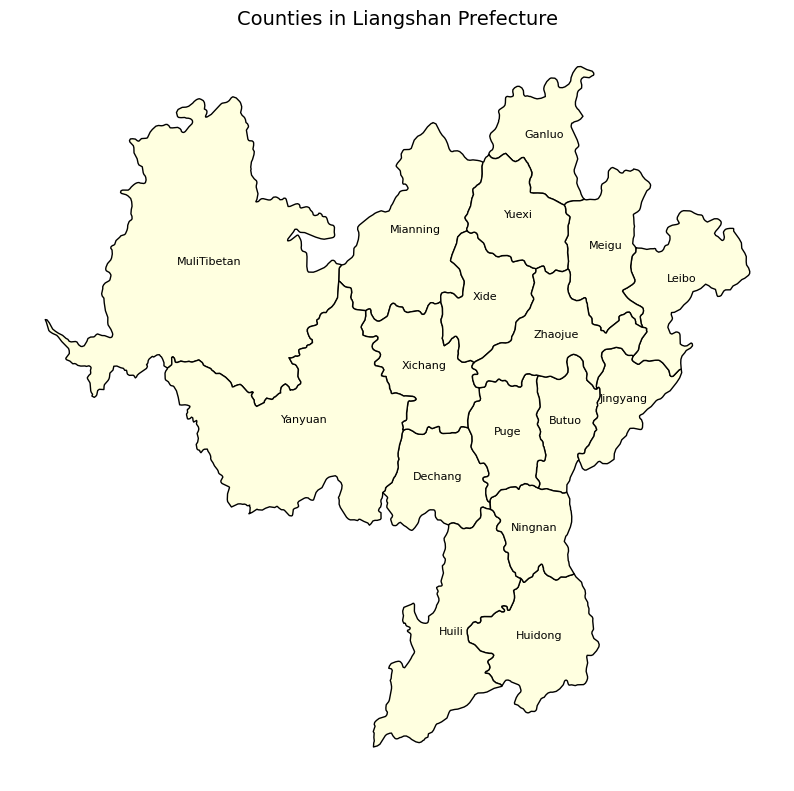

In [17]:
liangshan = gdf[gdf["Prefecture"] == "LiangshanYi"]

fig, ax = plt.subplots(figsize=(10, 10))
liangshan.plot(ax=ax, edgecolor='black', facecolor='lightyellow')

for idx, row in liangshan.iterrows():
    if row["geometry"].centroid.is_empty:
        continue
    plt.annotate(
        text=row["County"],
        xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
        ha='center',
        fontsize=8
)

ax.set_title("Counties in Liangshan Prefecture", fontsize=14)
ax.axis("off")
plt.show()

In [18]:
# Generate Google Maps search URLs for 金阳 and 旌阳 in Sichuan
def google_maps_search_link(place, province="四川", country="中国"):
    import urllib.parse
    query = f"{place} {province} {country}"
    base_url = "https://www.google.com/maps/search/"
    return base_url + urllib.parse.quote(query)

jinyang_url = google_maps_search_link("金阳")
jingyang_url = google_maps_search_link("旌阳")

print("Google Maps link for 金阳 (Jinyang), Sichuan:")
print(jinyang_url)
print("\nGoogle Maps link for 旌阳 (Jingyang), Sichuan:")
print(jingyang_url)



Google Maps link for 金阳 (Jinyang), Sichuan:
https://www.google.com/maps/search/%E9%87%91%E9%98%B3%20%E5%9B%9B%E5%B7%9D%20%E4%B8%AD%E5%9B%BD

Google Maps link for 旌阳 (Jingyang), Sichuan:
https://www.google.com/maps/search/%E6%97%8C%E9%98%B3%20%E5%9B%9B%E5%B7%9D%20%E4%B8%AD%E5%9B%BD


It seems to be an error in the gadm dataset since 旌阳 (Jingyang) in GADM match the location of Jinyang 金阳 (Jinyang). 旌阳 (Jingyang) shoud be in Deyang prefecture...

In [19]:
print(gdf[gdf["Province"] == "Sichuan"]["Prefecture"].unique())
print("\n County")
print(gdf[gdf["Prefecture"] == "Deyang"]["County"].unique())



['Bazhong' 'Chengdu' 'Dazhou' 'Deyang' 'GarzêTibetan' "Guang'an"
 'Guangyuan' 'Leshan' 'LiangshanYi' 'Luzhou' 'Meishan' 'Mianyang'
 'Nanchong' 'Neijiang' 'Neijiang]]' 'NgawaTibetanandQiang' 'Panzhihua'
 'Suining' "Ya'an" 'Yibin' 'Zigong' 'Ziyang']

 County
['Deyang' 'Guanghan' 'Mianzhu' 'Shifang' 'Zhongjiang']


In [20]:
# For Ankang : correct the province name to Shaanxi

# For Ankang (Hanbing) and Qiangshang: Since it is classified as a "qu", there is no separate county-level division.

# For LiangshanYi : Jingyang in GADM seems to correspond to the location of Jinyang.

# For autonomous county of Bai and Pumi of Lanping: It likely corresponds to LanpingBaiandPumi.

for entry in counties:
    if entry.get('province') == 'Shanxi':
        entry['province'] = 'Shaanxi'
        #if entry.get('county') == 'Hanbing':
            #entry['county'] = 'Ankang'
        print(f"\nCorrected province name to: {entry['province']} - {entry['prefecture']} - {entry['county']}")

    # if entry.get('county') == 'Heshui':
    #     entry['county'] = entry['prefecture']
    #     print(f"\nCorrected county name to: {entry['province']} - {entry['prefecture']} - {entry['county']}")

    if entry.get('county') == 'Jinyang' : 
        entry['county'] = 'Jingyang'
        print(f"\nCorrected county name to: {entry['province']} - {entry['prefecture']} - {entry['county']}")

    if entry.get('county') == 'Autonomous county of Bai and Pumi of Laping' : 
        entry['county'] = "LanpingBaiandPumi"
        print(f"\nCorrected county name to: {entry['province']} - {entry['prefecture']} - {entry['county']}")


Corrected province name to: Shaanxi - Ankang - Hanbin

Corrected province name to: Shaanxi - Ankang - Baihe

Corrected county name to: Sichuan - LiangshanYi - Jingyang

Corrected county name to: Yunnan - NujiangLisu - LanpingBaiandPumi


In [21]:
# Check if all the counties are found now 
found, not_found = check_counties_in_gadm(counties, gdf)

Counties found in GADM:
Hebei - Handan - Daming
Hebei - Zhangjiakou - Xuanhua
Henan - Xinyang - Gushi
Henan - Nanyang - Sheqi
Henan - Xinxiang - Yanjin
Hunan - Huaihua - Yuanling
Hunan - Loudi - Shuangfeng
Shandong - Zibo - Yiyuan
Shandong - Heze - Cao
Shaanxi - Ankang - Baihe
Sichuan - Guang'an - Yuechi
Sichuan - LiangshanYi - Jingyang
Yunnan - NujiangLisu - LanpingBaiandPumi
Yunnan - Zhaotong - Yongshan

Counties NOT found in GADM:
Gansu - Qingyang - Heshui
  -> No match at: county level(s)
Shaanxi - Ankang - Hanbin
  -> No match at: county level(s)


In [22]:
# Add the boundary geometry of each county to the found list

# Add geometry to found counties from gdf
for entry in found:
    # Find the matching row in gdf
    match = gdf[
        (gdf["Province"] == entry.get("province")) &
        (gdf["Prefecture"] == entry.get("prefecture")) &
        (gdf["County"] == entry.get("county"))
    ]
    if not match.empty:
        # Store geometry as GeoJSON-like dict
        entry["geometry"] = mapping(match.iloc[0].geometry)
    else:
        entry["geometry"] = None  # fallback if not found

In [23]:
# For counties not found, try to get their boundary from OSM using osmnx

for idx, entry in enumerate(not_found):
    # Extract data dict from entry
    if isinstance(entry, tuple) and len(entry) > 0 and isinstance(entry[0], dict):
        data = entry[0]  # dict inside tuple
        entry_is_tuple = True
    elif isinstance(entry, dict):
        data = entry
        entry_is_tuple = False
    else:
        print(f"Unsupported entry format: {entry}")
        continue

    query_name = f"{data.get('county', '')}, {data.get('prefecture', '')}, {data.get('province', '')}, China"
    print(f"Querying OSM for: {query_name}")

    try:
        # Remove max_results argument, as it is not supported in some osmnx versions
        gdf_osm = ox.geocode_to_gdf(query_name)
        if not gdf_osm.empty:
            # Prefer polygons/multipolygons
            poly_gdf = gdf_osm[gdf_osm.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
            if not poly_gdf.empty:
                geom = poly_gdf.iloc[0].geometry
                print(f"Found polygon geometry for {query_name}: {geom.geom_type}")
                data['geometry'] = mapping(geom)
            else:
                # Fallback: use the first result (could be Point/LineString)
                geom = gdf_osm.iloc[0].geometry
                print(f"No polygon found, using geometry for {query_name}: {geom.geom_type}")
                data['geometry'] = mapping(geom)
        else:
            print(f"No geometry found for {query_name}")
            data['geometry'] = None
    except Exception as e:
        print(f"Error for {query_name}: {e}")
        data['geometry'] = None

    # If the entry was a tuple, update not_found with the modified dict inside the tuple
    if entry_is_tuple:
        # Replace the tuple in not_found with a new tuple containing the updated dict and any other elements
        not_found[idx] = (data,) + entry[1:]
    else:
        not_found[idx] = data


Querying OSM for: Heshui, Qingyang, Gansu, China
Found polygon geometry for Heshui, Qingyang, Gansu, China: Polygon
Querying OSM for: Hanbin, Ankang, Shaanxi, China
Found polygon geometry for Hanbin, Ankang, Shaanxi, China: Polygon


In [24]:
# Combine found and not_found into a single list for further analysis
all_counties = []

# found is a list of dicts
all_counties.extend(found)

# not_found may be a list of dicts or tuples with dicts as first element
for entry in not_found:
    if isinstance(entry, dict):
        all_counties.append(entry)
    elif isinstance(entry, tuple) and len(entry) > 0 and isinstance(entry[0], dict):
        all_counties.append(entry[0])
    else:
        print(f"Skipping entry with unexpected format in not_found: {entry}")


all_counties_df = pd.DataFrame(all_counties)
print(all_counties_df.head())
print(all_counties_df.info())


  province   prefecture   county  \
0    Hebei       Handan   Daming   
1    Hebei  Zhangjiakou  Xuanhua   
2    Henan      Xinyang    Gushi   
3    Henan      Nanyang    Sheqi   
4    Henan     Xinxiang   Yanjin   

                                            geometry  
0  {'type': 'MultiPolygon', 'coordinates': [(((11...  
1  {'type': 'MultiPolygon', 'coordinates': [(((11...  
2  {'type': 'MultiPolygon', 'coordinates': [(((11...  
3  {'type': 'MultiPolygon', 'coordinates': [(((11...  
4  {'type': 'MultiPolygon', 'coordinates': [(((11...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   province    16 non-null     object
 1   prefecture  16 non-null     object
 2   county      16 non-null     object
 3   geometry    16 non-null     object
dtypes: object(4)
memory usage: 644.0+ bytes
None


In [25]:
# Save all counties (combined DataFrame) to CSV for further analysis

all_counties_df.to_csv("../../focus_counties.csv", index=False, encoding="utf-8")


## Sampling Overview

For sampling, we will use the Google Static Maps API to obtain satellite images of each county. 
We aim to optimize  the number of samples required while still ensuring adequate coverage of each area.

In [26]:
all_counties_df["geometry"] = all_counties_df["geometry"].apply(shape)

focus_gdf = gpd.GeoDataFrame(all_counties_df, geometry="geometry")

In [27]:
# Calculate the best UTM zone for each county based on centroid longitude
def get_utm_zone(longitude):
    """Given a longitude in degrees, return the UTM zone number (1-60)."""
    return int((longitude + 180) // 6) + 1

# Compute centroid longitude for each county
focus_gdf['centroid_lon'] = focus_gdf.geometry.centroid.x

# Assign UTM zone for each county
focus_gdf['utm_zone'] = focus_gdf['centroid_lon'].apply(get_utm_zone)
focus_gdf['utm_crs'] = focus_gdf['utm_zone'].apply(lambda z: f"EPSG:{32600 + z}")

# Show a sample of the assigned UTM zones and CRS
print(focus_gdf[['province', 'prefecture', 'county', 'centroid_lon', 'utm_zone', 'utm_crs']])


    province   prefecture             county  centroid_lon  utm_zone  \
0      Hebei       Handan             Daming    115.240668        50   
1      Hebei  Zhangjiakou            Xuanhua    115.072826        50   
2      Henan      Xinyang              Gushi    115.695957        50   
3      Henan      Nanyang              Sheqi    112.979143        49   
4      Henan     Xinxiang             Yanjin    114.218579        50   
5      Hunan      Huaihua           Yuanling    110.591599        49   
6      Hunan        Loudi         Shuangfeng    112.174453        49   
7   Shandong         Zibo             Yiyuan    118.177145        50   
8   Shandong         Heze                Cao    115.540379        50   
9    Shaanxi       Ankang              Baihe    109.907555        49   
10   Sichuan     Guang'an             Yuechi    106.411594        48   
11   Sichuan  LiangshanYi           Jingyang    103.190004        48   
12    Yunnan  NujiangLisu  LanpingBaiandPumi     99.260527      

In [28]:
# Calculate the area of each county using its assigned UTM zone
areas = []
for idx, row in focus_gdf.iterrows():
    utm_crs = row['utm_crs']
    geom = row['geometry']
    # Project the geometry to the county's UTM CRS for accurate area calculation
    geom_proj = gpd.GeoSeries([geom], crs="EPSG:4326").to_crs(utm_crs).iloc[0]
    area_km2 = geom_proj.area / 1e6  # convert from m^2 to km^2
    areas.append(area_km2)
focus_gdf['area_km2'] = areas

# Show the calculated areas using UTM
print(focus_gdf[['province', 'prefecture', 'county','area_km2']].sort_values(by='area_km2', ascending=False).reset_index(drop=True))


    province   prefecture             county     area_km2
0      Hunan      Huaihua           Yuanling  5792.169932
1     Yunnan  NujiangLisu  LanpingBaiandPumi  4390.926975
2    Shaanxi       Ankang             Hanbin  3607.770912
3      Henan      Xinyang              Gushi  2934.058010
4      Gansu     Qingyang             Heshui  2933.981362
5     Yunnan     Zhaotong           Yongshan  2783.168607
6      Hebei  Zhangjiakou            Xuanhua  2505.822025
7   Shandong         Heze                Cao  1964.911376
8   Shandong         Zibo             Yiyuan  1733.571708
9      Hunan        Loudi         Shuangfeng  1713.735430
10   Sichuan  LiangshanYi           Jingyang  1594.135153
11   Sichuan     Guang'an             Yuechi  1465.450956
12   Shaanxi       Ankang              Baihe  1431.626178
13     Henan      Nanyang              Sheqi  1123.678665
14     Hebei       Handan             Daming  1063.269894
15     Henan     Xinxiang             Yanjin   954.188461


In [40]:
# Calculate the number of samples needed to cover each county at 0.3m and 0.5m resolution
# Assume each sample is a square image of a given ground coverage (e.g., 512x512 pixels)

# Define image size in pixels
img_size_px = 512

# Calculate ground coverage per image (in meters)
coverage_03m = (img_size_px * 0.3) ** 2 / 1e6  # in km^2
coverage_05m = (img_size_px * 0.5) ** 2 / 1e6  # in km^2
coverage_1m = (img_size_px * 1) ** 2 / 1e6  # in km^2
coverage_10m = (img_size_px * 10) ** 2 / 1e6  # in km^2


# Calculate number of samples needed for each county
focus_gdf['samples_03m'] = (focus_gdf['area_km2'] / coverage_03m).apply(np.ceil).astype(int)
focus_gdf['samples_05m'] = (focus_gdf['area_km2'] / coverage_05m).apply(np.ceil).astype(int)
focus_gdf['samples_1m'] = (focus_gdf['area_km2'] / coverage_1m).apply(np.ceil).astype(int)
focus_gdf['samples_10m'] = (focus_gdf['area_km2'] / coverage_10m).apply(np.ceil).astype(int)

# Print a sample to check²
print(focus_gdf[['province', 'prefecture', 'county', 'area_km2', 'samples_03m', 'samples_05m', 'samples_1m', 'samples_10m']].sort_values(by='samples_03m', ascending=False).reset_index(drop=True))


    province   prefecture             county     area_km2  samples_03m  \
0      Hunan      Huaihua           Yuanling  5792.169932       245505   
1     Yunnan  NujiangLisu  LanpingBaiandPumi  4390.926975       186112   
2    Shaanxi       Ankang             Hanbin  3607.770912       152918   
3      Henan      Xinyang              Gushi  2934.058010       124362   
4      Gansu     Qingyang             Heshui  2933.981362       124359   
5     Yunnan     Zhaotong           Yongshan  2783.168607       117967   
6      Hebei  Zhangjiakou            Xuanhua  2505.822025       106211   
7   Shandong         Heze                Cao  1964.911376        83284   
8   Shandong         Zibo             Yiyuan  1733.571708        73479   
9      Hunan        Loudi         Shuangfeng  1713.735430        72638   
10   Sichuan  LiangshanYi           Jingyang  1594.135153        67569   
11   Sichuan     Guang'an             Yuechi  1465.450956        62114   
12   Shaanxi       Ankang             

In [47]:
total_samples_03m = focus_gdf['samples_03m'].sum()
total_samples_05m = focus_gdf['samples_05m'].sum()
total_samples_1m = focus_gdf['samples_1m'].sum()
total_samples_10m = focus_gdf['samples_10m'].sum()

print(f"Total samples needed at 0.3m resolution: {total_samples_03m}")
print(f"Total samples needed at 0.5m resolution: {total_samples_05m}")
print(f"Total samples needed at 1m resolution: {total_samples_1m}")
print(f"Total samples needed at 10m resolution: {total_samples_10m}")


Total samples needed at 0.3m resolution: 1610339
Total samples needed at 0.5m resolution: 579728
Total samples needed at 1m resolution: 144939
Total samples needed at 10m resolution: 1455


## Sampling optimizitation with landscape analysis 

The total number of samples required to map solar panels across large regions can be very high, so we will optimize our sampling strategy by focusing only on areas where solar panels are most likely to occur.

To achieve this efficiently, we use Google Earth Engine to compute land cover filters based on global datasets. Google Earth Engine provides access to the ESA WorldCover land cover map and enables large-scale geospatial raster processing, which would be difficult and computationally expensive to perform locally.

Following the methodology of Mapping photovoltaic power plants in China using Landsat, random forest, and Google Earth Engine (Zhang et al., 2021 [https://doi.org/10.1016/j.rse.2021.112667]), we use the ESA WorldCover land cover map (10 m resolution) to restrict our sampling to land cover types where solar panels are most likely to be found. According to Zhang et al. (2021), these include cropland, barren land, grassland, built-up areas, wetlands, and occasionally areas with sparse trees or open water.

By applying these land cover filters in Google Earth Engine, we limit our sampling to areas that are land-use appropriate for solar panel installation. This approach significantly reduces the number of required samples and ensures that we focus our efforts on the most promising locations for solar panel detection.

We assign a suitability score to each land cover type based on its appropriateness for solar panel installation. This scoring approach helps prioritize sampling and analysis efforts on locations with the greatest potential, improving efficiency and accuracy in detecting solar installations.

| **Land Cover Class (ESA WorldCover)** | **Code** | **Suitability Score** | **Explanation**                                                                |
| ------------------------------------- | -------- | --------------------- | ------------------------------------------------------------------------------ |
| **Built-up (Urban)**                  | 50       | **1.0**               | Rooftops, parking lots, and infrastructure are ideal for solar panels.         |
| **Cropland**                          | 40       | **1.0**               | Open, flat agricultural land is highly suitable for solar farms.               |
| **Bare/Sparse Vegetation**            | 60       | **0.8**               | Open soil or sparsely vegetated land can be used with minor preparation.       |
| **Grassland/Herbaceous**              | 30/20    | **0.5**               | Possible, but less efficient due to higher maintenance and shading.            |
| **Shrubland**                         | 10       | **0.3**               | Less ideal because of more vegetation and terrain challenges.                  |
| **Wetlands**                          | 80       | **0.2**               | Technically possible (floating panels) but rare and environmentally sensitive. |
| **Water bodies**                      | 90       | **0.1**               | Only feasible with floating solar farms; very low suitability.                 |
| **Forests & Others**                  | others   | **0.0**               | Generally unsuitable due to tree cover and conservation concerns.              |


You can find and run the GEE script for this project at:
https://code.earthengine.google.com/978e963cffcdf94f9502d9399da77497


Script overview:
- Loads the focus counties asset and the ESA WorldCover raster (https://code.earthengine.google.com/?asset=projects/fromglc/assets/focus_counties)
- Applies a mask to select only the desired land cover classes.
- Assigns a suitability score to each pixel.
- Exportsraster images (GeoTIFF files) for further analysis or sampling.

In [31]:
# Directory containing the exported GeoTIFFs from GEE
gee_export_dir = "../../GEE_exports"
tif_files = [f for f in os.listdir(gee_export_dir) if f.endswith('.tif')]

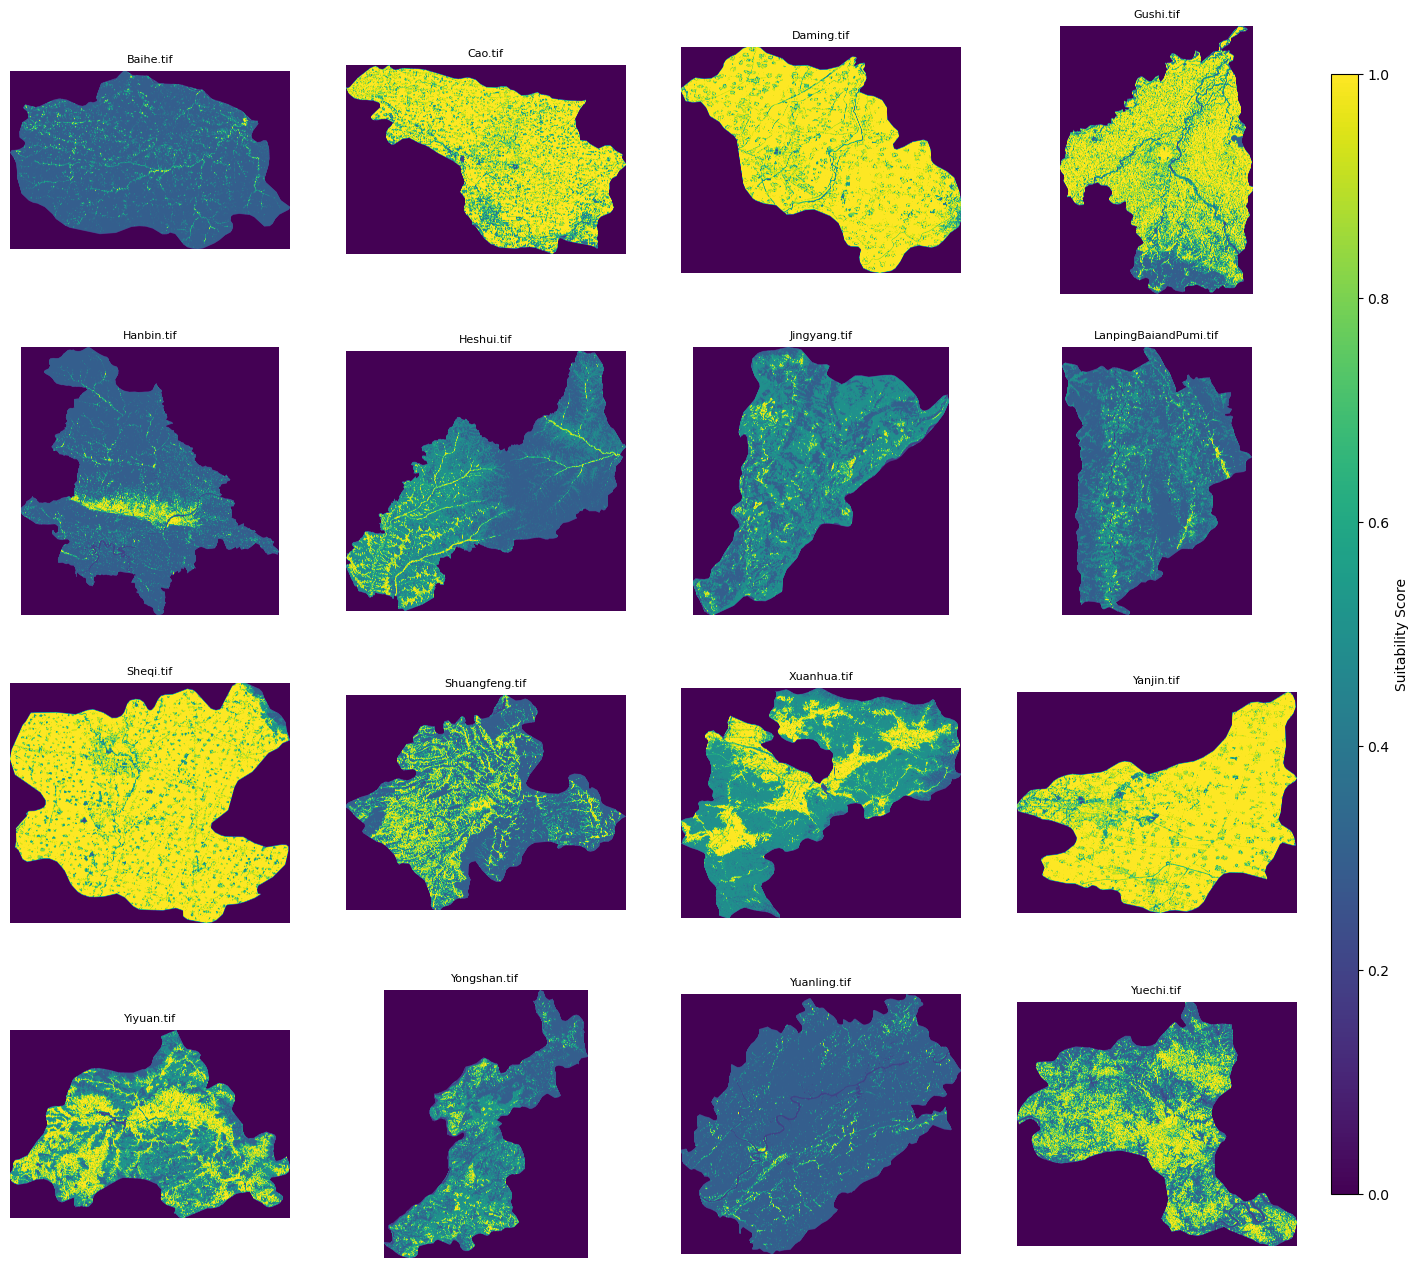

In [32]:
n_files = len(tif_files)
n_cols = 4
n_rows = int(np.ceil(n_files / n_cols))

# Leave extra space on the right for the colorbar by adjusting the figure size
fig_width = 4 * n_cols + 1.5  # add space for colorbar
fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, 4 * n_rows))
axes = axes.flatten()

im = None  # Will hold the last image handle for colorbar

for idx, filename in enumerate(tif_files):
    tif_path = os.path.join(gee_export_dir, filename)
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        # Mask out nodata values
        if src.nodata is not None:
            mask = (data != src.nodata)
            data = np.where(mask, data, np.nan)
        else:
            data = data.astype(float)
    ax = axes[idx]
    im = ax.imshow(data, cmap='viridis', vmin=0, vmax=1)
    ax.set_title(filename, fontsize=8)
    ax.axis('off')

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

# Make space for the colorbar on the right
fig.subplots_adjust(right=0.86)  # Shrink the grid to leave space for colorbar

# Add a dedicated axis for the colorbar (not overlaying images)
cbar_ax = fig.add_axes([0.88, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Suitability Score', fontsize=10)

plt.show()


In [33]:
# For each TIFF file, calculate the percentage of valid area with a suitability score above or equal to several thresholds.
thresholds = [0.1, 0.2, 0.3, 0.5, 0.8, 1.0]  # Thresholds to check (see score range above)
area_percentages = []

for filename in tif_files:
    tif_path = os.path.join(gee_export_dir, filename)
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        # Prepare a mask for valid (non-nodata) pixels
        if src.nodata is not None:
            valid_mask = (data != src.nodata)
            total_valid = np.sum(valid_mask)
        else:
            valid_mask = np.ones_like(data, dtype=bool)
            total_valid = data.size

        percent_dict = {'filename': filename}
        # For each threshold, compute the % of valid pixels above or equal to the threshold
        for thresh in thresholds:
            above_or_equal_thresh = np.sum((data >= thresh) & valid_mask)
            percent = (above_or_equal_thresh / total_valid) * 100.0 if total_valid > 0 else 0.0
            # Store as float
            percent_dict[f'percent_above_{str(thresh).replace(".","")}'] = float(percent)
        area_percentages.append(percent_dict)

# Convert results to a DataFrame for display
df_area_percent = pd.DataFrame(area_percentages)
print(df_area_percent)


                 filename  percent_above_01  percent_above_02  \
0               Baihe.tif         65.773382         65.773382   
1                 Cao.tif         52.275216         52.258187   
2              Daming.tif         51.520698         51.520698   
3               Gushi.tif         57.531863         57.521664   
4              Hanbin.tif         43.051388         43.051343   
5              Heshui.tif         41.943627         41.943627   
6            Jingyang.tif         44.189969         44.189969   
7   LanpingBaiandPumi.tif         59.661026         59.661026   
8               Sheqi.tif         67.752836         67.752629   
9          Shuangfeng.tif         46.991497         46.991391   
10            Xuanhua.tif         49.773378         49.770587   
11             Yanjin.tif         53.380018         53.380018   
12             Yiyuan.tif         53.060730         53.060597   
13           Yongshan.tif         33.321581         33.321581   
14           Yuanling.tif

In [34]:
print(df_area_percent.describe())

       percent_above_01  percent_above_02  percent_above_03  percent_above_05  \
count         16.000000         16.000000         16.000000         16.000000   
mean          51.273233         51.271321         50.824059         29.874998   
std            9.095416          9.094831          9.157803         18.458971   
min           33.321581         33.321581         32.499699          3.025687   
25%           43.980692         43.980692         43.487259         17.243841   
50%           51.897957         51.889442         51.698119         25.270444   
75%           56.976708         56.974097         55.712825         45.699554   
max           67.752836         67.752629         67.701330         63.066578   

       percent_above_08  percent_above_10  
count         16.000000         16.000000  
mean          21.097090         20.803558  
std           20.569729         20.501669  
min            2.417223          2.311627  
25%            3.418194          3.211205  
50%   

As we can see, by considering only the areas with a suitability score above 0.5 (which correspond to our areas of interest such as built-up land, grassland, cropland, etc. where residential solar farms could realistically be located) we can reduce the study area to almost 30% of the original total area.


In [35]:
def count_tiles(tif_path, threshold, grid_spacing):
    """
    This function divides a raster (TIFF) image into non-overlapping tiles, and counts how many of those tiles contain at least one pixel with a value greater than or equal to a given threshold.

    - Each tile covers an area up to (512 * grid_spacing) x (512 * grid_spacing) meters
    - The tile size is chosen so that it does not exceed this area, and is aligned to the TIFF's pixel grid (which is 10 meters per pixel)
    - The function returns the number of such tiles that contain at least one pixel above the threshold

    Args:
        tif_path (str): Path to the raster file.
        threshold (float): The minimum pixel value for a tile to be counted.
        grid_spacing (float): The desired sampling resolution in meters (e.g., 0.3 or 0.5 meters per pixel).

    Returns:
        int: Number of tiles with at least one pixel >= threshold.
        float: The actual ground size of each tile in meters.

    Note: The iteration uses the actual tile size in meters, but since the TIFF is at 10m resolution, the tile size in pixels is always a multiple of 10. The code ensures that the tile size does not exceed the maximum allowed, and that all parts of the image are covered.
    """
    # The TIFF pixels are at 10m resolution (i.e., each pixel covers 10x10 meters).
    max_tile_size_meters = 512 * grid_spacing
    tile_nb_pixels = int(np.floor(max_tile_size_meters / 10.0))
    if tile_nb_pixels < 1:
        tile_nb_pixels = 1  # Ensure at least 1 pixel per tile

    count = 0

    with rasterio.open(tif_path) as src:
        data = src.read(1, masked=True)
        height, width = data.shape

        # The following loops iterate over the raster in steps of the actual tile size (in pixels).
        # For each tile, we check if any pixel is >= threshold.
        for row_start in range(0, height, tile_nb_pixels):
            for col_start in range(0, width, tile_nb_pixels):
                row_end = min(row_start + tile_nb_pixels, height)
                col_end = min(col_start + tile_nb_pixels, width)
                tile = data[row_start:row_end, col_start:col_end]
                if np.any(tile >= threshold):
                    count += 1
        return count

In [36]:
count_tiles("../../GEE_exports/Baihe.tif", 0.5, 0.3)

35570

In [37]:

grid_spacings = [0.3, 0.5, 1.0]  # resolution of the satellite images

all_results = []  # To store all results for all files

for idx, filename in enumerate(tif_files):
    file_results = []
    tif_path = os.path.join(gee_export_dir, filename)  # Use full path to the TIFF file

    for threshold in thresholds:
        tile_counts = {}
        for spacing in grid_spacings:
            # For each grid spacing, count the number of tiles needed
            try:
                n_tiles = count_tiles(tif_path, threshold, spacing)
            except Exception as e:
                print(f"Error processing {tif_path} with threshold {threshold} and spacing {spacing}: {e}")
                n_tiles = None
            tile_counts[spacing] = n_tiles  # Store the result for this spacing
        # Create a DataFrame row for this threshold
        row = {"filename": filename, "threshold": threshold}
        for spacing in grid_spacings:
            row[f"tiles_{spacing}"] = tile_counts[spacing]
        file_results.append(row)
    # Create DataFrame for this file
    df_file = pd.DataFrame(file_results)
    print(f"\nResults for {filename}:")
    print(df_file)
    all_results.append(df_file)



Results for Baihe.tif:
    filename  threshold  tiles_0.3  tiles_0.5  tiles_1.0
0  Baihe.tif        0.1      76690      27791       6795
1  Baihe.tif        0.2      76690      27791       6795
2  Baihe.tif        0.3      76579      27773       6793
3  Baihe.tif        0.5      35570      18040       6032
4  Baihe.tif        0.8      17470       9770       4169
5  Baihe.tif        1.0      17254       9669       4145

Results for Cao.tif:
  filename  threshold  tiles_0.3  tiles_0.5  tiles_1.0
0  Cao.tif        0.1     107741      39039       9537
1  Cao.tif        0.2     107738      39039       9537
2  Cao.tif        0.3     107600      39013       9534
3  Cao.tif        0.5     107461      39000       9530
4  Cao.tif        0.8     107397      38998       9530
5  Cao.tif        1.0     107248      38974       9528

Results for Daming.tif:
     filename  threshold  tiles_0.3  tiles_0.5  tiles_1.0
0  Daming.tif        0.1      59520      21620       5298
1  Daming.tif        0.2     

KeyboardInterrupt: 

In [ ]:
# Concatenate all results into a single DataFrame
df_all = pd.concat(all_results, ignore_index=True)

# Group by threshold, then sum the tile columns for each grid spacing
grouped = df_all.groupby("threshold").agg({f"tiles_{spacing}": "sum" for spacing in grid_spacings}).reset_index()

print("\nTotal number of tiles across all counties (all files), for each threshold and grid spacing:")
print(grouped)



Total number of tiles across all counties (all files), for each threshold and grid spacing:
   threshold  tiles_0.3  tiles_0.5  tiles_1.0
0        0.1    2019927     732062     178958
1        0.2    2019924     732062     178958
2        0.3    2009964     729718     178693
3        0.5    1494219     597184     163710
4        0.8    1016682     427502     128926
5        1.0     995224     418434     126584


Note: It seems a bit weird...the number of tiles didn't really decrease as expected and sometimes even increased. Let's try to understand why...


In [ ]:
for col in grouped.columns:
    if col == "threshold":
        continue
    # Extract the resolution as an integer (e.g., from "tiles_100" get 100)
    try:
        resolution = col.split("_")[1]
        resolution = float(resolution)
    except (IndexError, ValueError):
        print(f"Could not parse resolution from column name: {col}")
        continue
    tile_area_km2 = (resolution * 512) ** 2 / 1e6
    area_km2 = grouped[col].fillna(0) * tile_area_km2
    print(f"Total area (km²) for grid spacing {resolution}m at each threshold:")
    print(area_km2)


Total area (km²) for grid spacing 0.3m at each threshold:
0    47656.056914
1    47655.986135
2    47421.000253
3    35253.049098
4    23986.537759
5    23480.280023
Name: tiles_0.3, dtype: float64
Total area (km²) for grid spacing 0.5m at each threshold:
0    47976.415232
1    47976.415232
2    47822.798848
3    39137.050624
4    28016.771072
5    27422.490624
Name: tiles_0.5, dtype: float64
Total area (km²) for grid spacing 1.0m at each threshold:
0    46912.765952
1    46912.765952
2    46843.297792
3    42915.594240
4    33797.177344
5    33183.236096
Name: tiles_1.0, dtype: float64


In [ ]:
tif_area_results = []

for filename in tif_files:
    tif_path = os.path.join(gee_export_dir, filename)
    with rasterio.open(tif_path) as src:
        data = src.read(1)  # Read the first band
        # If nodata is defined, mask out nodata pixels
        if src.nodata is not None:
            total_pixels = np.count_nonzero(data != src.nodata)
        else:
            total_pixels = np.count_nonzero(~np.isnan(data))
    # Each pixel is 10m x 10m = 100 m^2
    area_m2 = total_pixels * 100
    area_km2 = area_m2 / 1e6
    tif_area_results.append({
        "filename": filename,
        "total_pixels": total_pixels,
        "area_m2": area_m2,
        "area_km2": area_km2
    })

# Optionally, create a DataFrame for all results
df_tif_areas = pd.DataFrame(tif_area_results)
print(df_tif_areas.sort_values(by='area_km2', ascending=False).reset_index(drop=True))

                 filename  total_pixels      area_m2    area_km2
0            Yuanling.tif     116694496  11669449600  11669.4496
1              Hanbin.tif     100031400  10003140000  10003.1400
2            Yongshan.tif      95022378   9502237800   9502.2378
3              Heshui.tif      86643970   8664397000   8664.3970
4   LanpingBaiandPumi.tif      82764513   8276451300   8276.4513
5             Xuanhua.tif      66382776   6638277600   6638.2776
6               Gushi.tif      60461505   6046150500   6046.1505
7                 Cao.tif      45941140   4594114000   4594.1140
8          Shuangfeng.tif      41311880   4131188000   4131.1880
9            Jingyang.tif      40932138   4093213800   4093.2138
10             Yiyuan.tif      40580386   4058038600   4058.0386
11             Yuechi.tif      39419576   3941957600   3941.9576
12              Baihe.tif      25975929   2597592900   2597.5929
13             Daming.tif      25684330   2568433000   2568.4330
14             Yanjin.tif

Interestingly, the total area calculated from the tif files is almost double the area calculated from the GADM boundaries.

This could be because the tif mask includes extra pixels outside the strict GADM county boundaries. 
Another possible reason is that the area calculation from the tif assumes each pixel is exactly 10m x 10m, but due to map projection distortions and reprojection, the true ground area covered by each pixel may differ slightly from 100 m^2.

However, despite this much larger area, the number of tiles generated did not increase proportionally.
So by filtering on landcover using this method, we can expect to sample fewer tiles.


In [ ]:
print(grouped)

   threshold  tiles_0.3  tiles_0.5  tiles_1.0
0        0.1    2019927     732062     178958
1        0.2    2019924     732062     178958
2        0.3    2009964     729718     178693
3        0.5    1494219     597184     163710
4        0.8    1016682     427502     128926
5        1.0     995224     418434     126584


Based on the results, a threshold of 0.5 appears to be a good compromise. 
At this threshold, there is a noticeable decrease in the number of samples, and it includes the areas relevant to our study where residential solar panels could be present.


In [ ]:
tif_area_results = []

for filename in tif_files:
    tif_path = os.path.join(gee_export_dir, filename)
    with rasterio.open(tif_path) as src:
        data = src.read(1)  # Read the first band
        # Only count pixels with value > 0.5 and not nodata
        if src.nodata is not None:
            mask = (data != src.nodata) & (data > 0.5)
        else:
            mask = (~np.isnan(data)) & (data > 0.5)
        total_pixels = np.count_nonzero(mask)
    # Each pixel is 10m x 10m = 100 m^2
    area_m2 = total_pixels * 100
    area_km2 = area_m2 / 1e6
    tif_area_results.append({
        "filename": filename,
        "total_pixels": total_pixels,
        "area_m2": area_m2,
        "area_km2": area_km2
    })

# Optionally, create a DataFrame for all results
df_tif_areas = pd.DataFrame(tif_area_results)
print(df_tif_areas.sort_values(by='area_km2', ascending=False).reset_index(drop=True))

                 filename  total_pixels     area_m2   area_km2
0               Gushi.tif      24939122  2493912200  2493.9122
1                 Cao.tif      20251370  2025137000  2025.1370
2               Sheqi.tif      12223353  1222335300  1222.3353
3              Daming.tif      12173788  1217378800  1217.3788
4              Yanjin.tif      10717548  1071754800  1071.7548
5             Xuanhua.tif       9800200   980020000   980.0200
6              Yiyuan.tif       8512632   851263200   851.2632
7              Yuechi.tif       8187634   818763400   818.7634
8          Shuangfeng.tif       6265704   626570400   626.5704
9            Yongshan.tif       4029956   402995600   402.9956
10             Heshui.tif       3687679   368767900   368.7679
11             Hanbin.tif       3505072   350507200   350.5072
12           Yuanling.tif       2820766   282076600   282.0766
13  LanpingBaiandPumi.tif       2149765   214976500   214.9765
14           Jingyang.tif       1293808   129380800   1

In [ ]:
print(sum(df_tif_areas['area_km2']))

13121.5909
